# 安装依赖并导入Python库

In [37]:
# transformers: HuggingFace的模型与Tokenizer库
# datasets: 数据处理与评估（部分功能）
# evaluate: BLEU评估工具
# sentencepiece: T5使用的分词器依赖
# matplotlib: 绘制收敛曲线
!pip install transformers datasets evaluate sentencepiece matplotlib -q

import json
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import T5ForConditionalGeneration, AutoTokenizer, AdamW
import matplotlib.pyplot as plt
from tqdm import tqdm
import evaluate

# 检查是否有GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("当前使用设备:", device)

当前使用设备: cuda


# 定义 QADataset 数据集类

In [38]:
class QADataset(Dataset):
    """
    自定义问答数据集类：
    - 将 context 和 question 拼接为输入
    - 将 answer 作为目标序列
    """
    def __init__(self, file_path, tokenizer, max_input_len=256, max_output_len=64):
        self.data = [json.loads(line) for line in open(file_path, 'r', encoding='utf-8')]
        self.tokenizer = tokenizer
        self.max_input_len = max_input_len
        self.max_output_len = max_output_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        input_text = f"context: {item['context']} question: {item['question']}"
        target_text = item['answer']

        input_enc = self.tokenizer(
            input_text, truncation=True, padding='max_length',
            max_length=self.max_input_len, return_tensors='pt'
        )
        target_enc = self.tokenizer(
            target_text, truncation=True, padding='max_length',
            max_length=self.max_output_len, return_tensors='pt'
        )

        return {
            'input_ids': input_enc['input_ids'].squeeze(),
            'attention_mask': input_enc['attention_mask'].squeeze(),
            'labels': target_enc['input_ids'].squeeze()
        }

# 加载 Tokenizer 和 数据

In [39]:
model_name = "uer/t5-base-chinese-cluecorpussmall"
tokenizer = AutoTokenizer.from_pretrained(model_name)

train_path = "F:/ProjectDemo/Demo_1/Data/train.json"
dev_path = "F:/ProjectDemo/Demo_1/Data/dev.json"

train_dataset = QADataset(train_path, tokenizer, max_input_len=256, max_output_len=64)
dev_dataset = QADataset(dev_path, tokenizer, max_input_len=256, max_output_len=64)

# 截取少量样本以加速训练
#train_dataset.data = train_dataset.data[:100]
#dev_dataset.data = dev_dataset.data[:20]

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=4)

print("训练样本数量:", len(train_dataset))
print("验证样本数量:", len(dev_dataset))

训练样本数量: 100
验证样本数量: 20
第一个样本输入解码: context : 第 35 集 雪 见 缓 缓 张 开 眼 睛 ， 景 天 又 惊 又 喜 之 际 ， 长 卿 和 紫 萱 的 仙 船 驶 至 ， 见 众 人 无 恙 ， 也 十 分 高 兴 。 众 人 登 船 ， 用 尽 合 力 把 自 身 的 真 气 和 水 分 输 给 她 。 雪 见 终 于 醒 过 来 了 ， 但 却 一 脸 木 然 ， 全 无 反 应 。 众 人 向 常 胤 求 助 ， 却 发 现 人 世 界 竟 没 有 雪 见 的 身 世 纪 录 。 长 卿 询 问 清 微 的 身 世 ， 清 微 语 带 双 关 说 一 切 上 了 天 界 便 有 答 案 。 长 卿 驾 驶 仙 船 ， 众 人 决 定 立 马 动 身 ， 往 天 界 而 去 。 众 人 来 到 一 荒 山 ， 长 卿 指 出 ， 魔 界 和 天 界 相 连 。 由 魔 界 进 入 通 过 神 魔 之 井 ， 便 可 登 天 。 众 人 至 魔 界 入 口 ， 仿 若 一 黑 色 的 蝙 蝠 洞 ， 但 始 终 无 法 进 入 。 后 来 花 楹 发 现 只 要 有 翅 膀 便 能 飞 入 。 于 是 景 天 等 人 打 下 许
第一个样本标签: 第 35 集


# 加载 T5 模型与优化器

In [40]:
model = T5ForConditionalGeneration.from_pretrained(model_name).to(device)
optimizer = AdamW(model.parameters(), lr=3e-5)

print("模型加载完成，参数量:", sum(p.numel() for p in model.parameters()))

模型加载完成，参数量: 214532352


# 高效训练函数

Epoch 1/1: 100%|█████████████████████████████████████████| 25/25 [10:50<00:00, 26.03s/it, loss=9.18]


Epoch 1 Average Loss: 9.4331


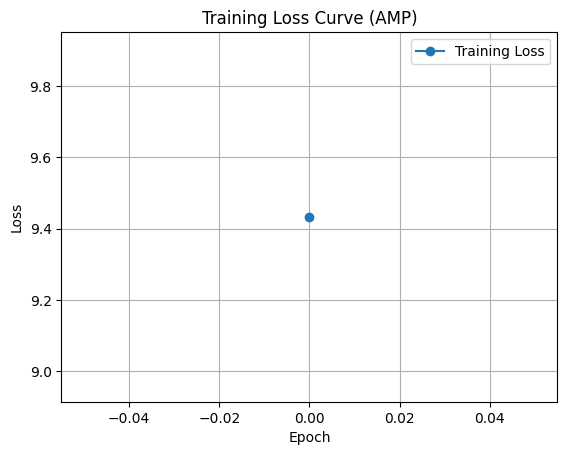

In [41]:
from torch import autocast, amp
scaler = amp.GradScaler('cuda')

def train_model_amp(model, train_loader, optimizer, epochs=1, accumulation_steps=1):
    train_losses = []
    model.train()

    for epoch in range(epochs):
        epoch_loss = 0.0
        loop = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs}", ncols=100)
        optimizer.zero_grad()

        for step, batch in enumerate(loop):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # AMP 混合精度训练
            with autocast(device_type='cuda'):
                outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss / accumulation_steps

            scaler.scale(loss).backward()

            if (step + 1) % accumulation_steps == 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()

            epoch_loss += loss.item() * accumulation_steps
            loop.set_postfix(loss=loss.item() * accumulation_steps)

        avg_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_loss)
        print(f"Epoch {epoch + 1} Average Loss: {avg_loss:.4f}")

    return train_losses

EPOCHS = 5
ACCUMULATION_STEPS = 2
train_losses = train_model_amp(model, train_loader, optimizer,
                               epochs=EPOCHS,
                               accumulation_steps=ACCUMULATION_STEPS)

plt.plot(train_losses, marker='o', label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve (AMP)")
plt.legend()
plt.grid()
plt.show()

# BLEU评估

In [42]:
bleu_metric = evaluate.load("sacrebleu")

def evaluate_bleu(model, data_loader, tokenizer):
    model.eval()
    preds, refs = [], []

    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating", ncols=100):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels']

            outputs = model.generate(input_ids=input_ids, attention_mask=attention_mask, max_length=64)
            pred_texts = tokenizer.batch_decode(outputs, skip_special_tokens=True)
            label_texts = tokenizer.batch_decode(labels, skip_special_tokens=True)

            preds.extend(pred_texts)
            refs.extend([[text] for text in label_texts])

    bleu_score = bleu_metric.compute(predictions=preds, references=refs)
    print("BLEU分数:", bleu_score)

    for i in range(3):
        print(f"预测: {preds[i]} | 真实: {refs[i][0]}")

    return bleu_score

evaluate_bleu(model, dev_loader, tokenizer)

Evaluating: 100%|█████████████████████████████████████████████████████| 5/5 [03:37<00:00, 43.50s/it]


BLEU分数: {'score': 0.0, 'counts': [0, 0, 0, 0], 'totals': [52, 32, 22, 13], 'precisions': [0.0, 0.0, 0.0, 0.0], 'bp': 0.5949780474073959, 'sys_len': 52, 'ref_len': 79}
预测: extra0 extra6 extra2 extra2 | 真实: 年 基 准 利 率 4. 35 %
预测: extra0 extra6 extra2 extra2 | 真实: 4. 35 %
预测: extra0 extra6 | 真实: 系 列


{'score': 0.0,
 'counts': [0, 0, 0, 0],
 'totals': [52, 32, 22, 13],
 'precisions': [0.0, 0.0, 0.0, 0.0],
 'bp': 0.5949780474073959,
 'sys_len': 52,
 'ref_len': 79}

# 样本预测

In [43]:
def predict(model, tokenizer, context, question):
    model.eval()
    input_text = f"context: {context} question: {question}"
    input_ids = tokenizer.encode(input_text, return_tensors='pt', truncation=True, max_length=256).to(device)

    with torch.no_grad():
        outputs = model.generate(input_ids=input_ids, max_length=64, num_beams=4)

    return tokenizer.decode(outputs[0], skip_special_tokens=True)

# 测试预测
test_context = "违规分为:一般违规扣分、严重违规扣分、出售假冒商品违规扣分,淘宝网每年12月31日24:00点会对符合条件的扣分做清零处理。"
test_question = "淘宝扣分什么时候清零"
print("预测答案:", predict(model, tokenizer, test_context, test_question))

预测答案: extra0 extra1 extra2 extra3 extra4 extra5 extra6 extra6 extra9 extra6 extra9 extra9 extra9 extra9 extra9 extra6 extra6 extra6
